## SIT789 Task-2.2C

In [1]:
import numpy as np
import cv2 as cv
import math
from matplotlib import pyplot as plt

Read fisherman image file

In [2]:
img_fisherman = cv.imread('fisherman.jpg') #load image
img_gray_fisherman = cv.cvtColor(img_fisherman, cv.COLOR_BGR2GRAY)

Horizontal derivative of image

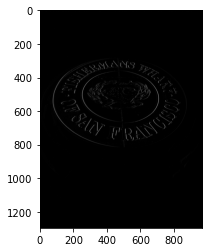

In [3]:
D_x = np.float32([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8
der_x_fisherman = cv.filter2D(img_gray_fisherman, -1, D_x)
plt.imshow(der_x_fisherman, 'gray')

Vertical derivative of image

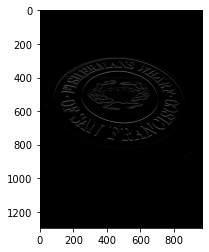

In [4]:
D_y = np.float32([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) / 8
der_y_fisherman = cv.filter2D(img_gray_fisherman, -1, D_y)
plt.imshow(der_y_fisherman, 'gray')

In [5]:
def get_image_orientation(height, width, der_x, der_y, ori_img_gray):    
    for i in range(0, height):
        for j in range(0, width):
            if (der_x[i, j] == 0) and (der_y[i, j] == 0):
                ori_img_gray[i, j] = math.inf
            else:
                radian_angle = math.atan2(der_y[i, j], der_x[i, j])
                ori_img_gray[i, j] = (radian_angle * 180) / math.pi
                ori_img_gray[i,j] = round(ori_img_gray[i, j] + 90)
    return ori_img_gray            

In [6]:
def get_histogram(ori_image):
    image_hist = []
    for i in range(0, 180):
        pixel_occurence = np.count_nonzero(ori_image == i)
        image_hist.append(pixel_occurence)
    return image_hist

In [7]:
def plot_histogram(image_hist):
    plt.plot(image_hist)    
    plt.show()

Edge orientation histogram for fisherman image

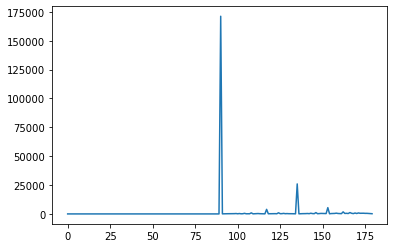

In [8]:
height_fisherman, width_fisherma = img_gray_fisherman.shape
ori_img_gray_fisherman = np.zeros((height_fisherman, width_fisherma), np.float32)
ori_fisherman = get_image_orientation(height_fisherman, width_fisherma, der_x_fisherman, der_y_fisherman, ori_img_gray_fisherman)
ori_fisherman_without_inf = ori_fisherman[ori_fisherman != math.inf]
fisherman_hist = get_histogram(ori_fisherman_without_inf)
plot_histogram(fisherman_hist)

Read empire image

In [9]:
img_empire = cv.imread('empire.jpg') #load image
img_gray_empire = cv.cvtColor(img_empire, cv.COLOR_BGR2GRAY)

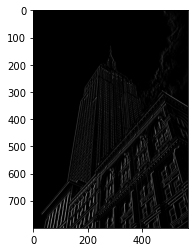

In [10]:
der_x_empire = cv.filter2D(img_gray_empire, -1, D_x)
plt.imshow(der_x_empire, 'gray')

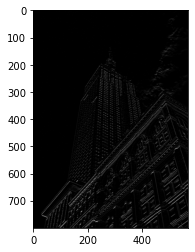

In [11]:
der_y_empire = cv.filter2D(img_gray_empire, -1, D_y)
plt.imshow(der_y_empire, 'gray')

Edge orientation histogram for empire image

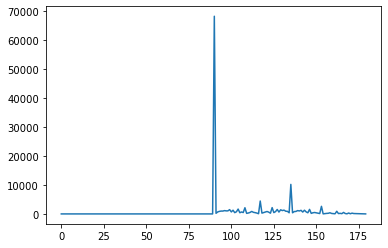

In [12]:
height_empire, width_empire = img_gray_empire.shape
ori_img_gray_empire = np.zeros((height_empire, width_empire), np.float32) #gradient orientation of img_gray
ori_empire = get_image_orientation(height_empire, width_empire, der_x_empire, der_y_empire, ori_img_gray_empire)
ori_empire_without_inf = ori_empire[ori_empire != math.inf]
empire_hist = get_histogram(ori_empire_without_inf)
plot_histogram(empire_hist)

## Document Skew Estimation

In [13]:
doc = cv.imread('doc.jpg', 0) #Note that the second parameter of imread is set to 0
threshold = 200
ret, doc_bin = cv.threshold(doc, threshold, 255, cv.THRESH_BINARY)
cv.imwrite('doc_bin.png', doc_bin)

True

Step-1

In [14]:
closing_se = np.ones((1, 15), np.int) #structuring element for closing

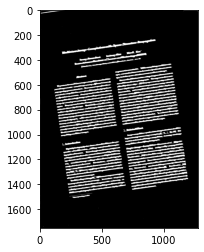

In [15]:
doc_bin = 255 - doc_bin #convert black/white to white/black
closing = cv.morphologyEx(doc_bin, cv.MORPH_CLOSE, closing_se)
plt.imshow(closing, 'gray')

In [16]:
opening_se = np.ones((8, 8), np.int) #structuring element for opening

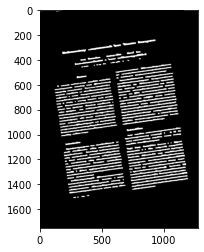

In [17]:
opening = cv.morphologyEx(closing, cv.MORPH_OPEN, opening_se)
plt.imshow(opening, 'gray')

Step-2

In [18]:
# connected component labelling
num_labels, labels_im = cv.connectedComponents(opening)

In [19]:
def ExtractConnectedComponents(num_labels, labels_im):
    connected_components = [[] for i in range(0, num_labels)]
    height, width = labels_im.shape
    for i in range(0, height):
        for j in range(0, width):
            if labels_im[i, j] >= 0:
                connected_components[labels_im[i, j]].append((j, i))
    return connected_components

In [20]:
connected_components = ExtractConnectedComponents(num_labels, labels_im)

Step-3

In [21]:
def FindOrientation(cc):
    mx = 0
    my = 0
    mxx = 0
    myy = 0
    mxy = 0
    for i in range(0, len(cc)):
        mx += cc[i][0] # cc[i][0] is used to store the x coordinate of pixel cc[i]
        my += cc[i][1] # cc[i][1] is used to store the y coordinate of pixel cc[i]
    mx /= len(cc)
    my /= len(cc)
    for i in range(0, len(cc)):
        dx = cc[i][0] - mx
        dy = cc[i][1] - my
        mxx += (dx * dx)
        myy += (dy * dy)
        mxy += (dx * dy)
    mxx /= len(cc)
    myy /= len(cc)
    mxy /= len(cc)
    theta = - math.atan2(2 * mxy, mxx - myy) / 2
    return theta

In [22]:
orientations = np.zeros(num_labels, np.float32)
for i in range(0, num_labels):
    orientations[i] = FindOrientation(connected_components[i])

Step-4

In [24]:
import statistics
orientation = statistics.median(orientations)
orientation

0.13556331

Step-5

True

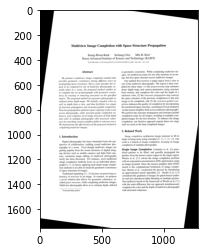

In [24]:
# rotate image
height, width = doc.shape
c_x = (width - 1) / 2.0 # column index varies in [0, width-1]
c_y = (height - 1) / 2.0 # row index varies in [0, height-1]
c = (c_x, c_y) # A point is defined by x and y coordinate
M = cv.getRotationMatrix2D(c, -orientation * 180 / math.pi, 1)
doc_deskewed = cv.warpAffine(doc, M, (width, height))
plt.imshow(doc_deskewed, 'gray')
cv.imwrite('doc_deskewed.png', doc_deskewed)

Dskew image doc_1.jpg

In [25]:
doc_1 = cv.imread('doc_1.jpg', 0) #Note that the second parameter of imread is set to 0
threshold = 200
ret_1, doc_bin_1 = cv.threshold(doc_1, threshold, 255, cv.THRESH_BINARY)
cv.imwrite('doc_1_bin.png', doc_bin_1)

True

In [26]:
doc_bin_1 = 255 - doc_bin_1 #convert black/white to white/black

True

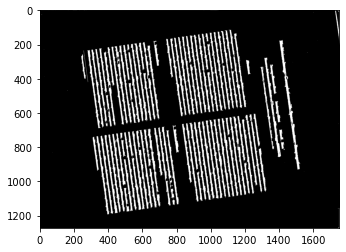

In [27]:
closing_se_1 = np.ones((15, 1), np.int) #structuring element for closing
closing_1 = cv.morphologyEx(doc_bin_1, cv.MORPH_CLOSE, closing_se_1)
plt.imshow(closing_1, 'gray')
cv.imwrite('doc_1_closing.png', closing_1)

True

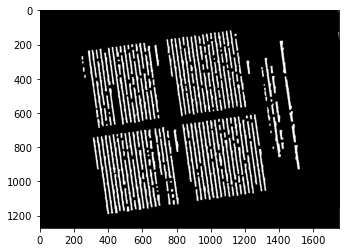

In [28]:
opening_1 = cv.morphologyEx(closing_1, cv.MORPH_OPEN, opening_se)
plt.imshow(opening_1, 'gray')
cv.imwrite('doc_1_opening.png', opening_1)

In [29]:
# connected component labelling
num_labels_1, labels_im_1 = cv.connectedComponents(opening_1)

In [30]:
connected_components_1 = ExtractConnectedComponents(num_labels_1, labels_im_1)

In [31]:
orientations_1 = np.zeros(num_labels_1, np.float32)
for i in range(0, num_labels_1):
    orientations_1[i] = FindOrientation(connected_components_1[i])

In [32]:
import statistics
orientation_1 = statistics.median(orientations_1)

True

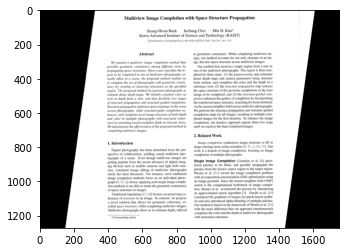

In [33]:
# rotate image
height_1, width_1 = doc_1.shape
c_x_1 = (width_1 - 1) / 2.0 # column index varies in [0, width-1]
c_y_1 = (height_1 - 1) / 2.0 # row index varies in [0, height-1]
c_1 = (c_x_1, c_y_1) # A point is defined by x and y coordinate
M_1 = cv.getRotationMatrix2D(c_1, -orientation_1 * 180 / math.pi, 1)
doc_deskewed_1 = cv.warpAffine(doc_1, M_1, (width_1, height_1))
plt.imshow(doc_deskewed_1, 'gray')
cv.imwrite('doc_deskewed_1.png', doc_deskewed_1)